**Import Libraries**

In [ ]:
!pip install hyperas
!pip install hyperopt

# Import Libraries
import re
import math
import keras
import string
import pickle
import logging
import zipfile
import nltk.data
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as ss
from operator import add
import numpy.linalg as la
import keras.backend as K
from keras.models import *
import bs4 as BeautifulSoup
import datetime as datetime
from keras import optimizers
import sklearn.metrics as skm
from keras import regularizers
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import sklearn.preprocessing as sp
from subprocess import check_output
from sklearn.decomposition import PCA
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from sklearn.preprocessing import normalize
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import multilabel_confusion_matrix
from keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.layers import BatchNormalization, advanced_activations
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.layers import Concatenate, Dropout, Activation, Bidirectional, Dense, Embedding, LSTM, Input, Reshape, dot, GRU
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
import random, os, sys
import numpy as np
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer
from sklearn.preprocessing import OneHotEncoder
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass

Using TensorFlow backend.


In [ ]:
# Run this code to be able to read CSV/XLSX files from google drive
# You will first need to save the dataset and any other files first onto google drive
# This method is faster than importing directly from the local directory
# Running this code will prompt you to access your google drive, copy the link once you have signed in to finish running this code
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
  global drive
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
  authenticate()
  
  for fileId in fileIds:    
    
    downloaded = drive.CreateFile({"id": fileId[1]})
    downloaded.GetContentFile(fileId[0])

In [ ]:
from sklearn.preprocessing import LabelEncoder
# This is the sharable link of the file, you will need to input your dataset and obtain a shareable link

try:
  _ = open("train.csv", "r")
  print("opened")
  
except:
  downloadFiles([["BOA Data.xlsx", "1ef7VMXh0nFWFhmamKEF6ERR3tfARYUAq"]])
  print("downloaded")

#link = 'https://drive.google.com/open?id=1ef7VMXh0nFWFhmamKEF6ERR3tfARYUAq' # This is my own shareable link
#discard, id = link.split('=')
#download = drive.CreateFile({'id':id})
#download.GetContentFile('BOA Data.xlsx')

# Read data in, you will need to install xlrd package if unable to do so '!pip install xlrd'
data = pd.read_excel('BOA Data.xlsx')
print("\n")

# Rename the columns for later use 
data.rename(columns={
                     'bac_dig_atm_machine_type_txt':'Machine_Type',
                     'bac_dig_atm_low_high_volume_txt':'ATM_Volume',
                     'bac_dig_atm_premise_location_txt': 'Premise_Location',
                     'bac_dig_atm_region_txt': 'ATM_Region',
                     'Transaction Date': 'Transaction_Date',
                     'bac_dig_atm_cash_mix_txt': 'Cash_Mix',
                     'bac_dig_atm_city_txt': 'ATM_City',
                     'Transaction Type': 'Transaction_Type',
                     'Transaction Method': 'Transaction_Method',
                     'Check Cashing': 'Check_Cashing',
                     'Client Segment': 'Client_Segment',
                     'Overall Comment': 'Sentiment',
                     'OSAT Experience': 'Rating',
                     'Response Date and Time': 'Response_Date_and_Time',
                     'Response Date': 'Response_Date',
                     'Digital Entity or IVR': 'Digital_Entity_IVR',
                     'bac_dig_atm_address_txt': 'ATM_Address',
                     'bac_dig_atm_bc_id_txt': 'ATM_Id',
                     'bac_dig_atm_market_txt': 'ATM_Market',
                     'bac_dig_atm_msa_txt': 'ATM_Msa',
                     'bac_dig_atm_nfc_active_txt': 'ATM_Nfc_Active',
                     'bac_dig_atm_site_name_txt': 'ATM_Site_Name',
                     'bac_dig_atm_state_txt': 'ATM_State',
                     'bac_dig_atm_vendor_txt': 'ATM_Vendor',
                     'bac_dig_atm_terminal_id_txt': 'ATM_Terminal',                  
                     'Root Cause': 'Root_Cause',
                     'Legacy vs. NextGen': 'Legacy_Nextgen',
                     'Walk Up vs. Drive Up': 'Walkup_Driveup',
                     'Tier 1- Controllable vs. Uncontrollable': 'Tier_1',
                     'Tier 2 - General Theme': 'Tier_2',
                     'Tier 3 - Detailed Theme': 'Category',
                     'bac_dig_atm_type_txt': 'ATM Type',
                     'Issue Incidence': 'Issue_Incidence',
                     'Products Owned': 'Products_Owned'
}, inplace=True)

# Drop all empty rows and reset the index 
data = data.dropna(axis=0, subset=['Sentiment'])
data = data.dropna(axis=0, subset=['Rating'])
data = data.reset_index(drop=True)

# Change labelling for categorical variables
ordinal_label = data['Rating']
binary_label = data['Rating'].replace({0:0,1:0,2:0,3:0,4:0,5:0,6:1,7:1,8:1,9:1,10:1})
#data['Rating'] = data['Rating'].replace({0:0,1:0,2:0,3:0,4:0,5:0,6:1,7:1,8:1,9:1,10:1})
data['Transaction Date and Time'] = data['Transaction Date and Time'].dt.strftime("%d/%m/%Y, %H:%M:%S") # Convert datetime column to string
data[['Transaction_Season', 'Transaction_Time']] = data['Transaction Date and Time'].str.split(', ', expand=True)
# Transform the label
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'close to home' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with new atm' if pd.isnull(row['Category']) and 'new atm' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'perfect location' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'] ,axis=1)
data['Category'] = data.apply(lambda row: 'multi-denomination' if pd.isnull(row['Category']) and 'denomination' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'excellent' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'assistance' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'] ,axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'without any problem' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'flawless' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'satisfied' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'ease' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'fast' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'not far' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'quick' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'efficient' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'convenience' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'convenient' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no problem' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'smooth' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'good location' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'great help' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'perfect' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no hassle' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no fuss' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no complain' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'multi-denomination' if pd.isnull(row['Category']) and '20' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'multi-denomination' if pd.isnull(row['Category']) and '10' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'multi-denomination' if pd.isnull(row['Category']) and '50' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'very pleased' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'great' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'simpl' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'parking' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no line' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no issue' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'accura' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'friendly' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'pleasant' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'unhappy with position/location' if pd.isnull(row['Category']) and 'too high' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'functional' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'good access' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'not wait long' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'upgrade atm processing/add additional atms/locations' if pd.isnull(row['Category']) and 'more useful' in row['Sentiment'].lower() and row['Rating'] >= 8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'experienced technical issues' if pd.isnull(row['Category']) and 'not work' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'unhappy with position/location' if pd.isnull(row['Category']) and 'insecure' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with new features' if pd.isnull(row['Category']) and 'sunlight' in row['Sentiment'].lower() and row['Rating'] >= 9 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no interference' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'security' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'secure' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'rapid' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'never have' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'actually worked' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'no interference' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'more than one atm' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'upgrade atm processing/add additional atms/locations' if pd.isnull(row['Category']) and 'more than one transaction' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'prompt' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'in and out' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'i like' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'i love' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'helpful' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'other' if pd.isnull(row['Category']) and 'n/a' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and ':)' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'i like' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'i love' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'helpful' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'other' if pd.isnull(row['Category']) and 'n/a' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'unhappy with position/location' if pd.isnull(row['Category']) and 'difficult to reach' in row['Sentiment'].lower() else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with new features' if pd.isnull(row['Category']) and 'bigger' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'without any' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with new features' if pd.isnull(row['Category']) and 'new ones' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'available right away' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and '2 atms' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with atm positioning/location' if pd.isnull(row['Category']) and 'two atms' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'foreign language' if pd.isnull(row['Category']) and 'muy' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'foreign language' if pd.isnull(row['Category']) and 'entiendo' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'ez' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'other' if pd.isnull(row['Category']) and 'idk' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'unhappy with position/location' if pd.isnull(row['Category']) and 'hard to reach' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'happy with functionality/service' if pd.isnull(row['Category']) and 'generous' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'upgrade atm processing/add additional atms/locations' if pd.isnull(row['Category']) and 'is slow' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)
data['Category'] = data.apply(lambda row: 'upgrade atm processing/add additional atms/locations' if pd.isnull(row['Category']) and 'add more' in row['Sentiment'].lower() and row['Rating']>=8 else row['Category'],axis=1)

data['Category'] = data["Category"].str.lower().replace({
    '1-800 #':'experienced inconvenient transaction/servicing issues/improve servicing',
    'account locked':'experienced inconvenient transaction/servicing issues/improve servicing',
    'add canopy/cover': 'improve user interface/atm features/operation',
    'add location': 'upgrade atm processing/add additional atms/locations',
    'ata': 'experienced inconvenient transaction/servicing issues/improve servicing',
    'atm froze': 'experienced technical issues',
    'atm layout':'improve atm positioning/location',
    'card capture':'experienced technical issues',
    'card reader':'experienced technical issues',
    'cash deposit error':'experienced technical issues',
    'cash deposit unavailable':'experienced technical issues',
    'cash dispenser':'improve dispensing/incorrect denominations',
    'chaining':'improve deposit & withdrawal process/note condition',
    'check cashing':'improve user interface/atm features/operation',
    'check deposit error':'experienced technical issues',
    'check deposit unavailable': 'improve deposit & withdrawal process/note condition',
    'clean up surrounding area':'upgrade atm processing/add additional atms/locations',
    'closure of service':'upgrade atm processing/add additional atms/locations',
    'credit card':'experienced technical issues',
    'deposit error':'experienced technical issues',
    'deposit unavailable': 'experienced technical issues',
    'dip reader':'experienced technical issues',
    'door/parabit reader':'experienced technical issues',
    'drive-up height':'improve atm positioning/location',
    'drive-up layout':'improve atm positioning/location',
    'easier to use':'improve usage/accessibility instructions',
    'fees':'unhappy with excess charges',
    'fine as is':'happy with functionality/service',
    'foreign language': 'other',
    'funds availability/check hold':'improve deposit & withdrawal process/note condition',
    'handicap accessible':'improve user interface/atm features/operation',
    'happy with new features':'happy with functionality/service',
    'hours of operation':'experienced inconvenient transaction/servicing issues/improve servicing',
    'improve cash acceptance':'improve deposit & withdrawal process/note condition',
    'improve check acceptance':'improve deposit & withdrawal process/note condition',
    'improve customer service':'experienced inconvenient transaction/servicing issues/improve servicing',
    'improve privacy':'improve user interface/atm features/operation',
    'improve safety':'improve atm positioning/location',
    'improve signage': 'improve usage/accessibility instructions',
    'improve touchscreen':'improve user interface/atm features/operation',
    'increase account access':'improve deposit & withdrawal process/note condition',
    'increase daily withdrawal limit':'improve deposit & withdrawal process/note condition',
    'increase single transaction withdrawal': 'improve deposit & withdrawal process/note condition',
    'innovative idea':'improve user interface/atm features/operation',
    'key pad':'experienced technical issues',
    'language setting':'improve user interface/atm features/operation',
    'lighting':'improve user interface/atm features/operation',
    'long line':'upgrade atm processing/add additional atms/locations',
    'loud atm':'other',
    'make atms consistent':'upgrade atm processing/add additional atms/locations',
    'makes atms consistent':'upgrade atm processing/add additional atms/locations',
    'make process faster': 'upgrade atm processing/add additional atms/locations',
    'marketing':'other',
    'multi-denomination':'improve dispensing/incorrect denominations',
    'nfc reader':'improve deposit & withdrawal process/note condition',
    'no comment':'other',
    'overdraft notification':'unhappy with excess charges',
    'out of order':'experienced inconvenient transaction/servicing issues/improve servicing',
    'parabit reader unlocked': 'happy with functionality/service',
    'parking':'improve atm positioning/location',
    'pre-staging error': 'experienced technical issues',
    'quality of bill':'improve deposit & withdrawal process/note condition',
    'receipt issue':'experienced inconvenient transaction/servicing issues/improve servicing',
    'refresh atm':'upgrade atm processing/add additional atms/locations',
    'user interface':'improve user interface/atm features/operation',
    'vendor servicing':'experienced inconvenient transaction/servicing issues/improve servicing',
    'very safe':'happy with atm positioning/location',
    'slow atm transaction':'upgrade atm processing/add additional atms/locations',
    'sun glare':'improve user interface/atm features/operation',
    'survey issue':'sent incorrect information',
    'withdrawal error':'improve deposit & withdrawal process/note condition',
    'withdrawal unavailable':'improve deposit & withdrawal process/note condition',
})

# Add values into Tier 3-Detailed Theme
na_values = {'Category':'other',
             'Tier_2': 'other',
             'Tier_1': 'other',
             'Issue_Incidence': 'unknown',
             'Products_Owned': 'unknown'}
data = data.fillna(na_values)

transaction_season = pd.to_datetime(data['Transaction_Season'], format='%d/%m/%Y')
transaction_time = pd.to_datetime(data['Transaction_Time'], format='%H:%M:%S').dt.time  
season_list = []
time_list = []

for season in range(0,len(data['Transaction_Season']),1):
    if transaction_season[season].month == 9 or transaction_season[season].month == 10 or transaction_season[season].month == 11:
        season_list.append('Fall')
    elif transaction_season[season].month == 6 or transaction_season[season].month == 7 or transaction_season[season].month == 8:
        season_list.append('Summer')
    elif transaction_season[season].month == 3 or transaction_season[season].month == 4 or transaction_season[season].month == 5:
        season_list.append('Spring')
    elif transaction_season[season].month == 12 or transaction_season[season].month == 1 or transaction_season[season].month == 2:
        season_list.append('Winter')
        
for time in range(0,len(data['Transaction_Time']),1):
    if transaction_time[time].hour == 4 or transaction_time[time].hour == 5 or transaction_time[time].hour == 6 or transaction_time[time].hour == 7 or transaction_time[time].hour == 8 or transaction_time[time].hour == 9 or transaction_time[time].hour == 10 or transaction_time[time].hour == 11:
        time_list.append('Morning')
    elif transaction_time[time].hour == 12 or transaction_time[time].hour == 13 or transaction_time[time].hour == 14 or transaction_time[time].hour == 15 or transaction_time[time].hour == 16 or transaction_time[time].hour == 17:
        time_list.append('Afternoon')
    elif transaction_time[time].hour == 18 or transaction_time[time].hour == 19 or transaction_time[time].hour == 20 or transaction_time[time].hour == 21 or transaction_time[time].hour == 22 or transaction_time[time].hour == 23 or transaction_time[time].hour == 0 or transaction_time[time].hour == 1 or transaction_time[time].hour == 2 or transaction_time[time].hour == 3:
        time_list.append('Night')
        
data['Transaction_Season'] = pd.Series(season_list)
data['Transaction_Time'] = pd.Series(time_list)

print(data.info())
print("\n")

categorical_embeddings = []
for column in data.columns:
  if is_string_dtype(data[column]):
    categorical_embeddings.append(column)
for c in categorical_embeddings:
    print(c,':', data[c].nunique())

downloaded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29188 entries, 0 to 29187
Data columns (total 66 columns):
Response_Date_and_Time            29188 non-null datetime64[ns]
Response_Date                     29188 non-null object
Week                              29188 non-null int64
Month                             29188 non-null object
Age Range                         11673 non-null object
Language Preference               28543 non-null object
Client Tenure                     28542 non-null float64
Relationship Tenure               26440 non-null object
Products_Owned                    29188 non-null object
Account Status                    0 non-null float64
Affinity Group                    635 non-null object
Asset Range                       26602 non-null object
Party ID                          1361 non-null float64
Account Number                    1361 non-null float64
Transaction Date and Time         29188 non-null object
Transaction_Date                  2

**List of Functions**

In [ ]:
# List of optimizers
adam = optimizers.Adam(lr=0.001, epsilon=None,decay=0.002, amsgrad=True, clipnorm=0.8)
nadam = optimizers.Nadam(lr=0.001, epsilon=None, schedule_decay=0.004)
adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
adadelta = optimizers.Adadelta(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adagrad = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

# Required for Theil's uncertainty coefficient to work
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

# The uncertainty coefficient equation
def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
      
# Converting data to list format to match the network structure
def categorical_preprocess(train, test, variable_list, activate):
    input_train = []
    input_test = []  
    # Label encodes each feature
    for column in variable_list:
        raw_values = np.unique(train[column])
        value_map = {}
        for i in range(len(raw_values)):
            value_map[raw_values[i]] = i       
        input_train.append(train[column].map(value_map).values)
        input_test.append(test[column].map(value_map).fillna(0).values) 
    if activate==True:
        # Combine the word embeddings with categorical embeddings
        input_train.append(WX_train)
        input_test.append(WX_test)
    return input_train, input_test
  
# Taken from Ben Hamner's Repository
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

# Taken from Ben Hamner's Repository
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

# Taken from Ben Hamner's Repository
def quadratic_weighted_kappa(y, y_pred):
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

# Used to calculate the confusion matrix
def classification_metrics(true_label, test_sample, model, mode):
    if mode == 'binary_softmax':
      predicted_label = model.predict(test_sample).tolist()
      for i in range(len(predicted_label)):
        index_min = min(range(len(predicted_label[i])), key=predicted_label[i].__getitem__)
        if index_min == 0:
          predicted_label[i] = 1
        else:
          predicted_label[i] = 0
      converted_label = true_label.tolist()
      for i in range(len(converted_label)):
        if converted_label[i] == [0,1]:
          converted_label[i] = 1
        else:
          converted_label[i] = 0         
      tn, fp, fn, tp = confusion_matrix(converted_label, predicted_label).ravel()
      accuracy = np.round(((tp + tn)/(tp + tn + fp + fn))*100, 3)
      precision = np.round((tp/(tp+fp))*100, 3)
      recall = np.round((tp/(tp+fn))*100, 3)
      error_rate = np.round(((fp + fn)/(tp + tn + fp + fn))*100, 3)
      fpr = np.round((fp/(tn+fp))*100, 3)
      f1_score = np.round(2*precision*recall/(precision+recall),3)

      print("True Negatives:", tn)
      print("False Positives:", fp)
      print("False Negatives:", fn)
      print("True Positives:", tp)
      print("")
      print("Accuracy:", accuracy )
      print("Precision:", precision)
      print("Recall:", recall)
      print("Error Rate:", error_rate)
      print("False Positive Rate:", fpr)
      print("F1 Score:", f1_score)     
      
    elif mode == 'binary_sigmoid_0.75':
      predicted_label = model.predict(test_sample).flatten().tolist()
      for line in range(len(predicted_label)):
          if predicted_label[line] >= 0.75:
              predicted_label[line] = 1
          else:
             predicted_label[line] = 0 
      tn, fp, fn, tp = confusion_matrix(true_label, predicted_label).ravel()
      accuracy = np.round(((tp + tn)/(tp + tn + fp + fn))*100, 3)
      precision = np.round((tp/(tp+fp))*100, 3)
      recall = np.round((tp/(tp+fn))*100, 3)
      error_rate = np.round(((fp + fn)/(tp + tn + fp + fn))*100, 3)
      fpr = np.round((fp/(tn+fp))*100, 3)
      f1_score = np.round(2*precision*recall/(precision+recall),3)

      print("True Negatives:", tn)
      print("False Positives:", fp)
      print("False Negatives:", fn)
      print("True Positives:", tp)
      print("")
      print("Accuracy:", accuracy )
      print("Precision:", precision)
      print("Recall:", recall)
      print("Error Rate:", error_rate)
      print("False Positive Rate:", fpr)
      print("F1 Score:", f1_score)   
    
    elif mode == 'binary_sigmoid_0.5':
      predicted_label = model.predict(test_sample).flatten().tolist()
      for line in range(len(predicted_label)):
          if predicted_label[line] >= 0.5:
              predicted_label[line] = 1
          else:
             predicted_label[line] = 0 
      tn, fp, fn, tp = confusion_matrix(true_label, predicted_label).ravel()
      accuracy = np.round(((tp + tn)/(tp + tn + fp + fn))*100, 3)
      precision = np.round((tp/(tp+fp))*100, 3)
      recall = np.round((tp/(tp+fn))*100, 3)
      error_rate = np.round(((fp + fn)/(tp + tn + fp + fn))*100, 3)
      fpr = np.round((fp/(tn+fp))*100, 3)
      f1_score = np.round(2*precision*recall/(precision+recall),3)

      print("True Negatives:", tn)
      print("False Positives:", fp)
      print("False Negatives:", fn)
      print("True Positives:", tp)
      print("")
      print("Accuracy:", accuracy )
      print("Precision:", precision)
      print("Recall:", recall)
      print("Error Rate:", error_rate)
      print("False Positive Rate:", fpr)
      print("F1 Score:", f1_score)  
      
    elif mode == 'multiclass':
      predicted_label = model.predict(test_sample).tolist()
      for i in range(len(predicted_label)):
        index_max = max(range(len(predicted_label[i])), key=predicted_label[i].__getitem__)
        predicted_label[i] = index_max 
      converted_label = true_label.tolist()
      for i in range(len(converted_label)):
        index_max = np.argmax(converted_label[i])
        converted_label[i] = index_max
      # Print the weighted confusion matrix
      print(skm.classification_report(converted_label, predicted_label))
    
    elif mode == 'ordinal_regression':
      predicted_label = model.predict(test_sample).flatten()
      for i in range(len(predicted_label)):
        if predicted_label[i] <= 0.5:
          predicted_label[i] = 0
        elif predicted_label[i] > 0.5 and predicted_label[i] <= 1.5:
          predicted_label[i] = 1
        elif predicted_label[i] > 1.5 and predicted_label[i] <= 2.5:
          predicted_label[i] = 2
        elif predicted_label[i] > 2.5 and predicted_label[i] <= 3.5:
          predicted_label[i] = 3
        elif predicted_label[i] > 3.5 and predicted_label[i] <= 4.5:
          predicted_label[i] = 4
        elif predicted_label[i] > 4.5 and predicted_label[i] <= 5.5:
          predicted_label[i] = 5
        elif predicted_label[i] > 5.5 and predicted_label[i] <= 6.5:
          predicted_label[i] = 6
        elif predicted_label[i] > 6.5 and predicted_label[i] <= 7.5:
          predicted_label[i] = 7
        elif predicted_label[i] > 7.5 and predicted_label[i] <= 8.5:
          predicted_label[i] = 8
        elif predicted_label[i] > 8.5 and predicted_label[i] <= 9.5:
          predicted_label[i] = 9
        elif predicted_label[i] > 9.5:
          predicted_label[i] = 10
      qwk = quadratic_weighted_kappa(true_label, predicted_label)
      print('Agreement Between Raters:', np.round(qwk,3))

def ensemble_classification_metrics(true_label, categorical_sample, word_sample, model_1, model_2):
    pred_label_1 = model_1.predict(categorical_sample)
    pred_label_2 = model_2.predict(word_sample)
    avg_label = (np.add(pred_label_1*0.25, pred_label_2*0.75)/2).tolist()
    for i in range(len(avg_label)):
        index_max = max(range(len(avg_label[i])), key=avg_label[i].__getitem__)
        avg_label[i] = index_max 
    converted_label = true_label.tolist()
    for i in range(len(converted_label)):
        index_max = np.argmax(converted_label[i])
        converted_label[i] = index_max
    # Print the weighted confusion matrix
    print(skm.classification_report(converted_label, avg_label))
    
# Create embedding matrix 
def create_embedding(embedding_dim, embedding_file, vocab_size, max_length):
    def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
    embedding_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file))
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    c = 0 
    c1 = 0 
    w_Y = []
    w_No = []
    for word, i in tokenizer.word_index.items():
        if word in embedding_index:
            c +=1
            embedding_vector = embedding_index[word]
            w_Y.append(word)
        else:
            embedding_vector = None
            w_No.append(word)
            c1 +=1
        if embedding_vector is not None:    
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(vocab_size,
                                     embedding_dim,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=max_length,
                                     trainable=False)
    return embedding_matrix, embedding_layer
  
# Area under curve metric to provide an additional measure for model performance
def auc(y_true, y_pred):
    score, up_opt = tf.metrics.auc(y_true, y_pred)
    #score, up_opt = tf.contrib.metrics.streaming_auc(y_pred, y_true)    
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
       score = tf.identity(score)
    return score

# Corpus cleaning functions
def clean_sentence(text): 
  misspelled_mapping = {"instute":"install", "pickin":"picking",
                     "1st":"first", "2nd":"second",
                     "3rd":"third", "4th":"fourth",
                     "5th":"fifth", "6th":"sixth",
                     "7th":"seventh","8th":"eighth",
                     "9th":"ninth","10th":"tenth",
                     "!":' exclamation', "Y'all": "you all",
                     "A.T.M":'atm', 'setvice': 'service',
                     "usr": 'use', 'B of A': 'bank of america',
                     "atms":"atm","drive thru":"drive-thru", 
                     "ATM's":"atm", "Preferre": "prefer",
                     "1": "one", "2":"two", "3":"three", 
                     "4": "four", "5":"five", "6":"six",
                     "7":"seven", "8":"eight",
                     "9":"nine","10":"ten",}
  sentence=[]
  for word in text.split():
    if word in misspelled_mapping:
      word = word.replace(word, misspelled_mapping.get(word))
    else:
       # De-contract contractions
      word = word.lower()
      word = re.sub(r"(W|w)on(\'|\’)t ", "will not ", word)
      word = re.sub(r"(C|c)an(\'|\’)t ", "can not ", word)
      word = re.sub(r"(Y|y)(\'|\’)all ", "you all ", word)
      word = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", word)
      word = re.sub(r"(I|i)(\'|\’)m ", "i am ", word)
      word = re.sub(r"(A|a)in(\'|\’)t ", "is not ", word)
      word = re.sub(r"n(\'|\’)t ", " not ", word)
      word = re.sub(r"(\'|\’)re ", " are ", word)
      word = re.sub(r"(\'|\’)s ", " is ", word)
      word = re.sub(r"(\'|\’)d ", " would ", word)
      word = re.sub(r"(\'|\’)ll ", " will ", word)
      word = re.sub(r"(\'|\’)t ", " not ", word)
      word = re.sub(r"(\'|\’)ve ", " have ", word)
      # Clean number
      word = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', word)
      word = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', word)
      word = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', word)
    sentence.append(word)
  sentence = ' '.join(sentence) 
  return sentence

def clean_corpus(corpus):
  data=[]
  for sentence in corpus:
    sentence = clean_sentence(sentence)
    data.append(sentence)
  # Transform cleaned data back into a series
  data=pd.Series(data)
  return data

# Transformer code
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        outputs = Add()([outputs, q])
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn

class DecoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_att_layer  = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, dec_input, enc_output, self_mask=None, enc_mask=None):
        output, slf_attn = self.self_att_layer(dec_input, dec_input, dec_input, mask=self_mask)
        output, enc_attn = self.enc_att_layer(output, enc_output, enc_output, mask=enc_mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn, enc_attn

def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Encoder():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, \
                layers=6, dropout=0.1, word_emb=None, pos_emb=None):
        self.emb_layer = word_emb
        self.pos_layer = pos_emb
        self.emb_dropout = Dropout(dropout)
        self.layers = [EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout) for _ in range(layers)]
        
    def __call__(self, src_seq, src_pos, return_att=False, active_layers=999):
        x = self.emb_layer(src_seq)
        if src_pos is not None:
            pos = self.pos_layer(src_pos)
            x = Add()([x, pos])
        x = self.emb_dropout(x)
        if return_att: atts = []
        mask = Lambda(lambda x:GetPadMask(x, x))(src_seq)
        for enc_layer in self.layers[:active_layers]:
            x, att = enc_layer(x, mask)
            if return_att: atts.append(att)
        return (x, atts) if return_att else x

class Transformer():
    def __init__(self, len_limit, d_model=300, \
              d_inner_hid=512, n_head=20, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = True
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = fasttext_layer

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)
        #self.decoder = Decoder(d_model, d_inner_hid, n_head, layers, dropout)
        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None,))
        src_seq = src_seq_input
        src_pos = Lambda(self.get_pos_seq)(src_seq)
        if not self.src_loc_info: src_pos = None

        x = self.encoder(src_seq, src_pos, active_layers=active_layers)
        #x = self.decoder(tgt_emb, tgt_seq, src_seq, enc_output, active_layers=active_layers)
        x = GlobalAveragePooling1D()(x)
        outp = Dense(15, activation="softmax")(x)

        self.model = Model(inputs=src_seq_input, outputs=outp)
        self.model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Categorical Dense Network + Bi-directional LSTM 
def categorical_model(variable_list, classes, activation, loss, metrics, mode):

    # Define initial variables
    input_models = []
    output_embeddings = [] 

    for column in variable_list:

        # Create the embedding variable
        embedding_name = column + '_Embedding'

        # Define the embedding size
        total_unique_categories = data[column].nunique()
        embedding_size = int(min(np.ceil(total_unique_categories)/2,200))

        # One embedding layer for each categorical variable
        input_model = Input(shape=(1,))
        output_model = Embedding(total_unique_categories, embedding_size, name=embedding_name)(input_model)
        output_model = Reshape(target_shape=(embedding_size,))(output_model)

        # Appending all categorical inputs 
        input_models.append(input_model)

        # Appending all embeddings
        output_embeddings.append(output_model)
    
    # Set a mode to append a word embedding model to the categorical embeddings
    if mode == 'Append':
      word_embedding_input = Input(shape=(max_length,))
      word_embedding_output = fasttext_layer(word_embedding_input)
      rnn_layer = Bidirectional(LSTM(300, return_sequences=True))(word_embedding_output)
      rnn_layer = Attention(max_length)(rnn_layer)
      input_models.append(word_embedding_input)
      output_embeddings.append(rnn_layer)

    # Concatenate the model
    output = Concatenate()(output_embeddings)
    output = BatchNormalization(axis=-1,
                                momentum=0.99,
                                epsilon=0.001,
                                center=False,
                                scale=False,
                                beta_regularizer=None,
                                gamma_regularizer=None,
                                beta_constraint=None,
                                gamma_constraint=None,
                                moving_mean_initializer='zeros',
                                moving_variance_initializer='ones')(output)
    output = Dense(1000, 
                   kernel_initializer="uniform",
                   kernel_regularizer=regularizers.l2(0.01),
                   activity_regularizer=regularizers.l1(0.00)
                   )(output)
    output = advanced_activations.LeakyReLU(alpha=0.2)(output)
    output= Dropout(0.1)(output)
    output = BatchNormalization()(output)
    output = Dense(512, 
                   kernel_initializer="uniform",
                   kernel_regularizer=regularizers.l2(0.01),
                   activity_regularizer=regularizers.l1(0.00))(output)
    output = advanced_activations.LeakyReLU(alpha=0.2)(output)
    output= Dropout(0.1)(output)
    output = Dense(classes, activation=activation)(output)   
    categorical_model = Model(inputs = input_models, outputs=output)
    categorical_model.compile(loss=loss,
                              optimizer=adam, 
                              metrics=metrics)
    categorical_model.summary()
    return categorical_model

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**Theil's Uncertainty Coefficient & Correlation Matrix**

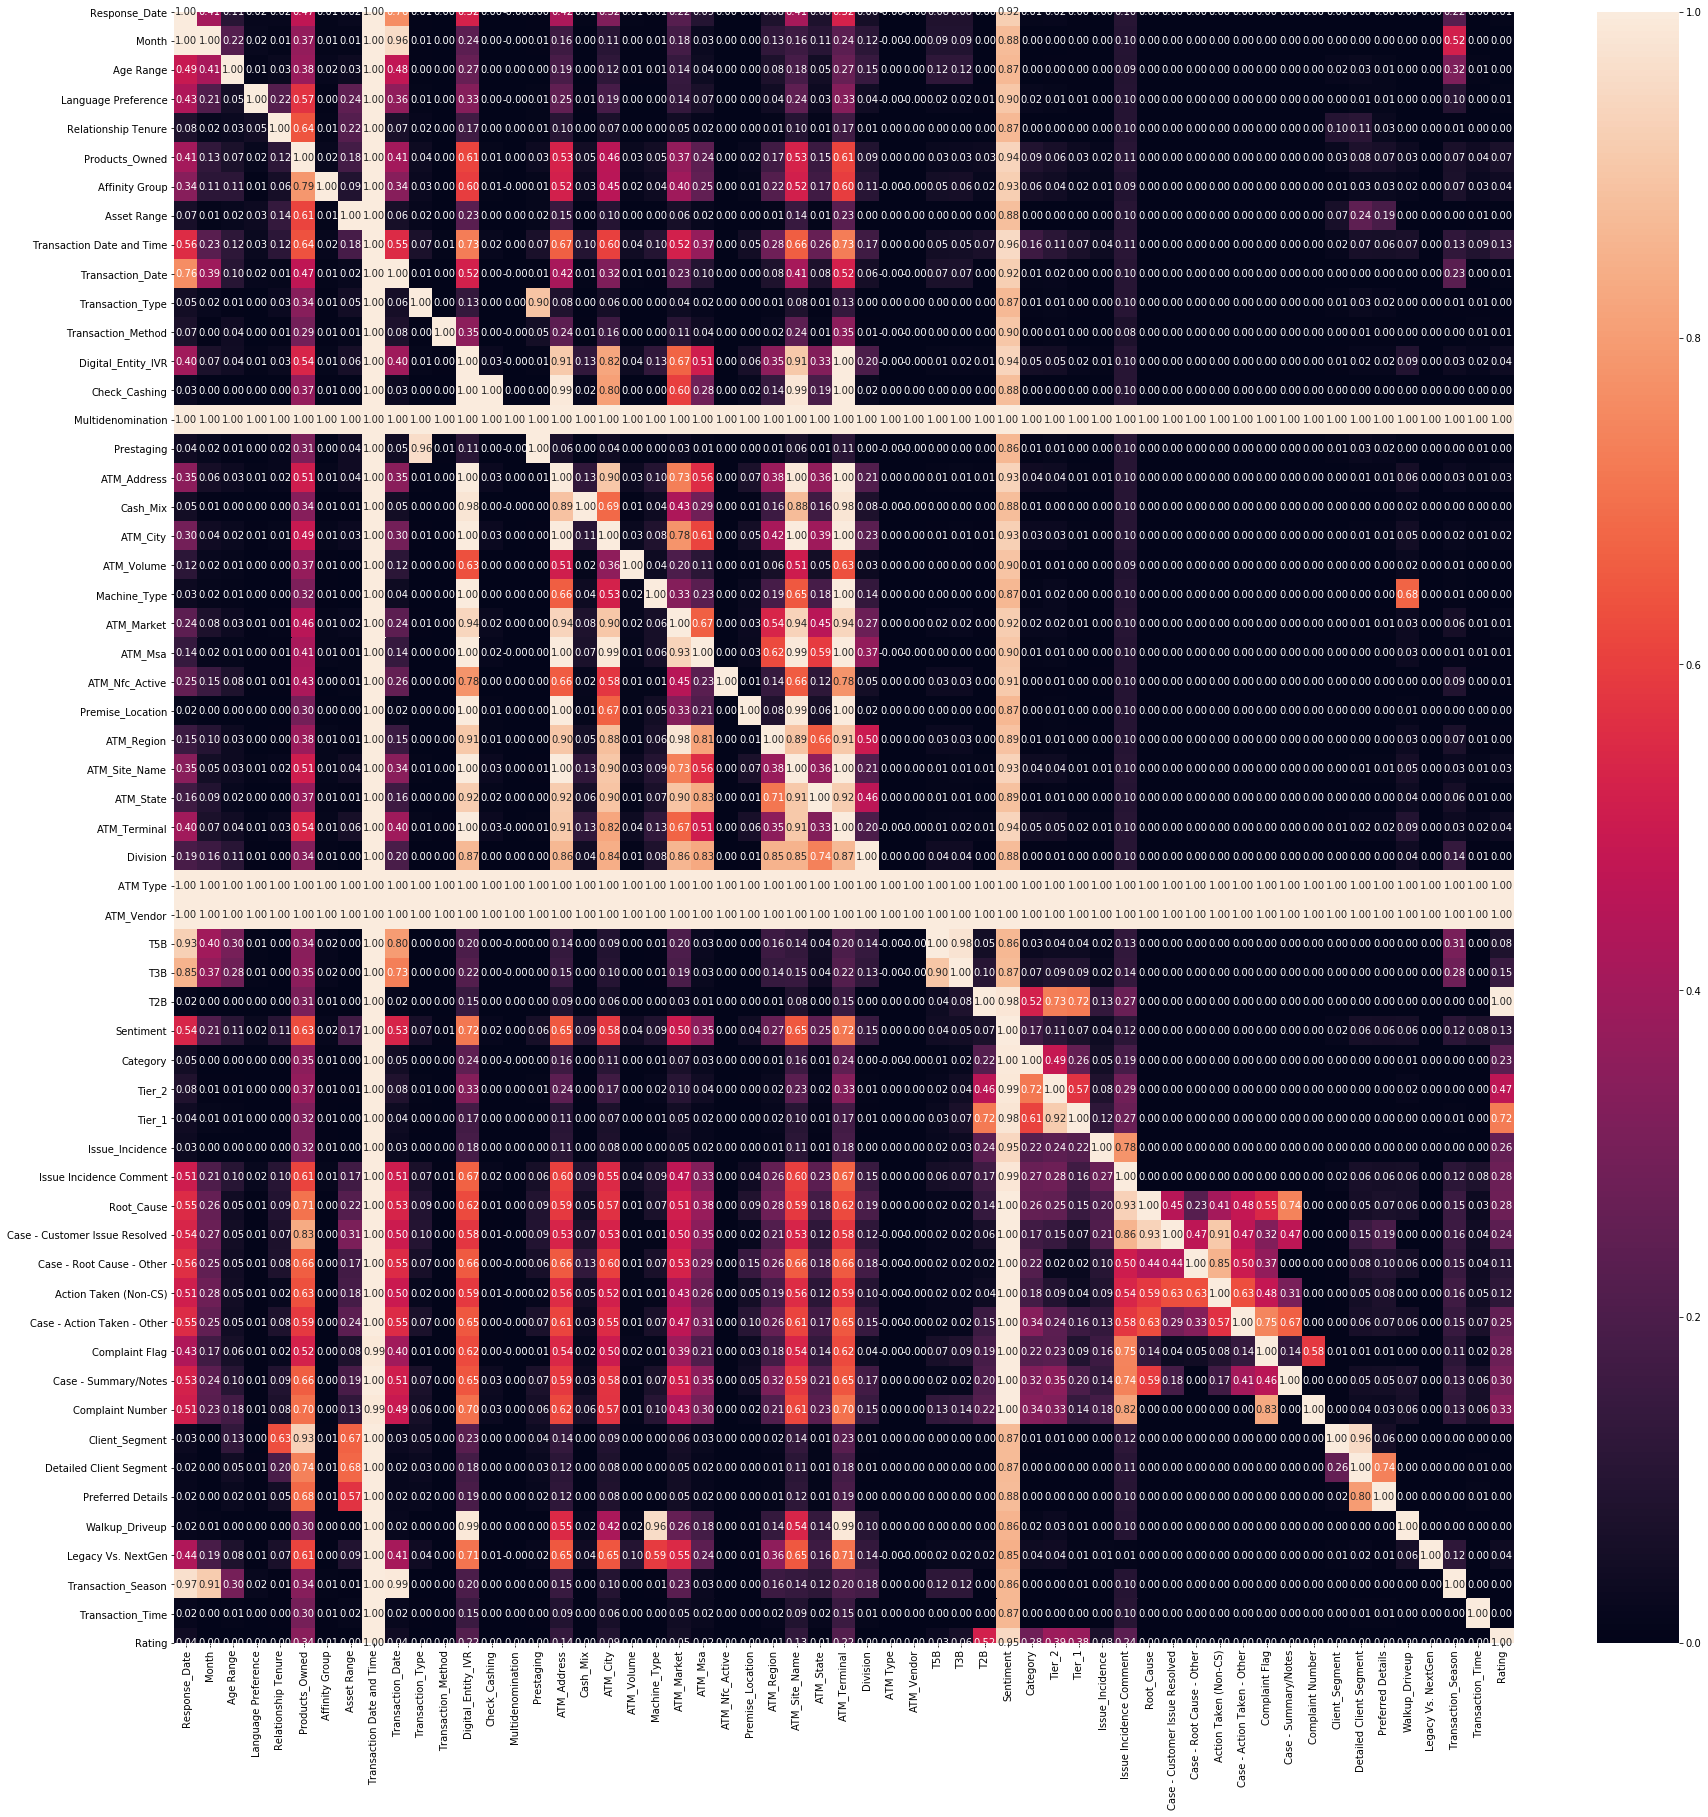

In [ ]:
# Use Theil's U to measure association between categorical variables
theilu = pd.DataFrame(index=categorical_embeddings+['Rating'],columns=data[categorical_embeddings+['Rating']].columns)
columns = data[categorical_embeddings+['Rating']].columns
for i in range(0,len(columns)):
  for j in range(0,len(columns)):
    u = theil_u(data[columns[j]].tolist(),data[columns[i]].tolist())
    theilu.loc[columns[j],columns[i]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(30,30))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

**Label Distribution**

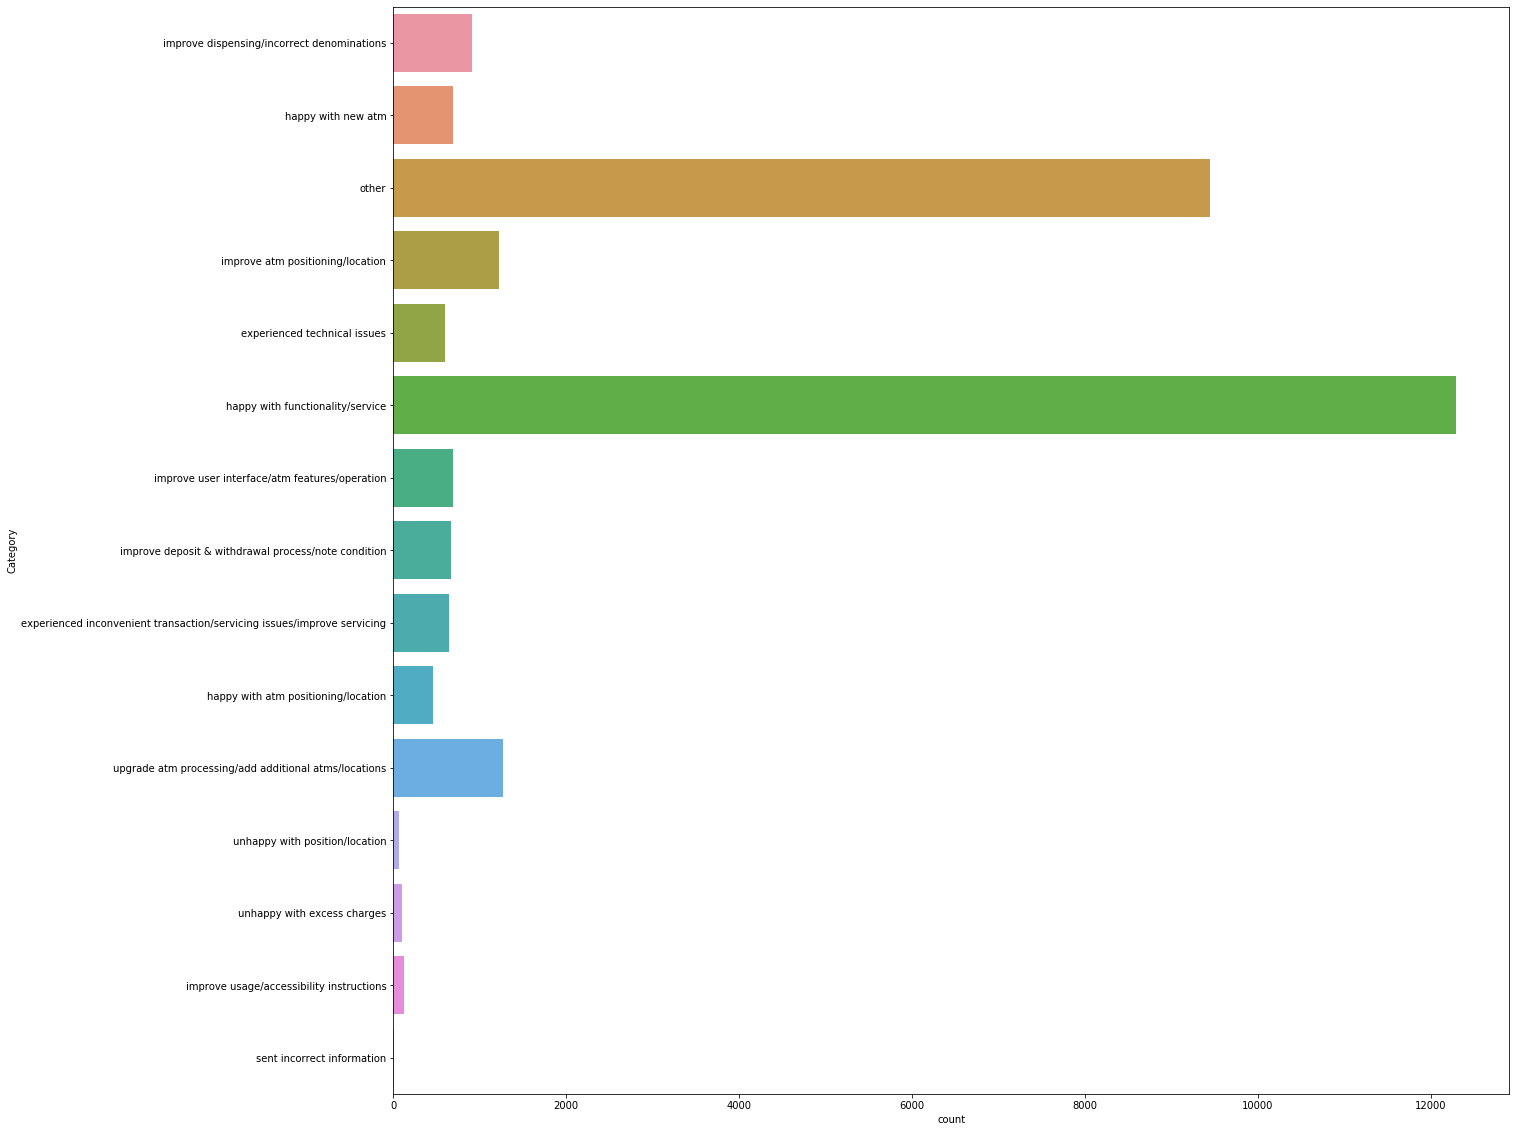

In [ ]:
f, variable = plt.subplots(figsize=(20,20), squeeze='true')
ax = sns.countplot(y='Category', orient='v',data=data, ax=variable)

**Data Processing**

In [ ]:
# Call the module 
LE = LabelEncoder()
# Label encode the target
rawLabels = np.array(data['Category'].str.lower())
LE.fit(np.unique(rawLabels))
LELabels = LE.transform(rawLabels)
LELabels = np.expand_dims(LELabels, axis=1)
OH = OneHotEncoder()
OH.fit(LELabels)
OHLabels = OH.transform(LELabels).toarray()
LELabels = LELabels.flatten()

# Clean the text data
data['Sentiment']=clean_corpus(data['Sentiment'])

# Tokenize data
tokenizer = Tokenizer(filters='"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(data['Sentiment'])
number_seq = tokenizer.texts_to_sequences(data['Sentiment'])

# Pad each sequence to the maximum length within
word_index = tokenizer.word_index
max_length = max([len(s.split()) for s in data['Sentiment']])
vocab_size = len(tokenizer.word_index) + 1
pad_sentiments = pad_sequences(number_seq, maxlen=max_length)

# Print dimensions
print('')
print('Found %s unique tokens' % len(word_index))
print('Shape of sentiment tensor:', pad_sentiments.shape)
print('Shape of label tensor:', data['Category'].shape)
print('')

# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)
  
# Creating a sequence of texts
word_seq = list(map(sequence_to_text, number_seq))

# Variables to be selected for the target
embeddings_category = ['Products_Owned', 'Digital_Entity_IVR', 'ATM_Site_Name', 'ATM_Terminal', 'ATM_Market']

# Split data into training, validation and testing fold for the categorical data
CX_train, CX_test, CY_train, CY_test = train_test_split(data[embeddings_category],
                                                            OHLabels,
                                                            test_size=0.2,
                                                            random_state=500)

# Split data into training, validation and testing fold for the text data
WX_train, WX_test, WY_train, WY_test = train_test_split(pad_sentiments, 
                                                        OHLabels, 
                                                        test_size=0.2, 
                                                        random_state=500)

# Split data into training, validation and testing fold for BERT
BX_train, BX_test, BY_train, BY_test = train_test_split(data['Sentiment'],
                                                        LELabels,
                                                        test_size=0.2,
                                                        random_state=500)

DATA_COLUMN = 'Sentiment'
LABEL_COLUMN = 'Category'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = list(pd.Series(LELabels).unique())

train=pd.DataFrame({DATA_COLUMN:BX_train, LABEL_COLUMN:BY_train})
test=pd.DataFrame({DATA_COLUMN:BX_test, LABEL_COLUMN:BY_test})                                                    

print("Categorical Train Sentiment:", CX_train.shape)
print("Categorical Train Label:", CY_train.shape)
print("Categorical Test Sentiment:", CX_test.shape)
print("Categorical Test Label:", CY_test.shape)
print('')

print("Word Train Sentiment:", WX_train.shape)
print("Word Train Label:", WY_train.shape)
print("Word Test Sentiment:", WX_test.shape)
print("Word Test Label:", WY_test.shape)
print('')

print("BERT Train Sentiment:", BX_train.shape)
print("BERT Train Label:", BY_train.shape)
print("BERT Test Sentiment:", BX_test.shape)
print("BERT Test Label:", BY_test.shape)
print('')

#train_unique, train_counts = np.unique(CY_train, return_counts=True)
#print('Number of pos and neg in categorical train:', dict(zip(train_unique, train_counts)))
#test_unique, test_counts = np.unique(CY_test, return_counts=True)
#print('Number of pos and neg in categorical test:', dict(zip(test_unique, test_counts)))

cat_train, cat_test = categorical_preprocess(CX_train, CX_test, embeddings_category, False)
combined_train, combined_test = categorical_preprocess(CX_train, CX_test, embeddings_category, True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)



Found 10548 unique tokens
Shape of sentiment tensor: (29188, 79)
Shape of label tensor: (29188,)

Categorical Train Sentiment: (23350, 5)
Categorical Train Label: (23350, 15)
Categorical Test Sentiment: (5838, 5)
Categorical Test Label: (5838, 15)

Word Train Sentiment: (23350, 79)
Word Train Label: (23350, 15)
Word Test Sentiment: (5838, 79)
Word Test Label: (5838, 15)

BERT Train Sentiment: (23350,)
BERT Train Label: (23350,)
BERT Test Sentiment: (5838,)
BERT Test Label: (5838,)



In [ ]:
Xtrain = open('store1.pckl', 'wb')
pickle.dump(cat_train, Xtrain)
Xtrain.close()

Ytrain = open('store2.pckl', 'wb')
pickle.dump(CY_train, Ytrain)
Ytrain.close()

Xtest = open('store3.pckl', 'wb')
pickle.dump(cat_test, Xtest)
Xtest.close()

Ytest = open('store4.pckl', 'wb')
pickle.dump(CY_test, Ytest)
Ytest.close()

Xtrain = open('store1.pckl', 'rb')
cat_train = pickle.load(Xtrain)
Xtrain.close()

Ytrain = open('store2.pckl', 'rb')
CY_train = pickle.load(Ytrain)
Ytrain.close()

Xtest = open('store3.pckl', 'rb')
cat_test = pickle.load(Xtest)
Xtest.close()

Ytest = open('store4.pckl', 'rb')
CY_test = pickle.load(Ytest)
Ytest.close()

**Word2Vec Embedding**

In [ ]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec(word_seq,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
w2v_model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
w2v_model_name = 'W2VCapstone.txt'
w2v_model.wv.save_word2vec_format(w2v_model_name) 

# Create the embedding layer
w2v_matrix, w2v_layer = create_embedding(300, 
                      w2v_model_name,
                      vocab_size, 
                      max_length)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


**Fasttext Word Embedding**

In [ ]:
# Get link from website
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# Initialize local repository
fasttext_repo = 'fasttext_model_repo'
# Extract zip file
with zipfile.ZipFile("wiki-news-300d-1M.vec.zip","r") as zip_ref:
    zip_ref.extractall(fasttext_repo)
# Location of embedding
fasttext_embedding = f'{fasttext_repo}/wiki-news-300d-1M.vec'
# Create embedding matrix, layer
fasttext_matrix, fasttext_layer = create_embedding(300, 
                      fasttext_embedding, 
                      vocab_size, 
                      max_length)

--2019-11-16 11:39:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  53.7MB/s    in 12s     

2019-11-16 11:39:40 (55.8 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



**GloVE Word Embedding**

In [ ]:
# Get link from website
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
# Initialize local repository
glove_repo = 'glove_model_repo'
# Extract zip file
with zipfile.ZipFile("glove.42B.300d.zip","r") as zip_ref:
    zip_ref.extractall(glove_repo)
# Location of embedding
glove_embedding = f'{glove_repo}/glove.42B.300d.txt'
# Create embedding matrix, layer
glove_matrix, glove_layer = create_embedding(300, 
                      glove_embedding,
                      vocab_size, 
                      max_length)

**Concatenated Word Embeddings**

In [ ]:
concat_matrix = np.concatenate((fasttext_matrix, glove_matrix, w2v_matrix), axis=1)  
np.shape(concat_matrix)

concat_layer=Embedding(vocab_size,
                          900,
                          embeddings_initializer=Constant(concat_matrix),
                          input_length=max_length,
                          trainable=False)

**Transformer Model**

In [ ]:
s2s = Transformer(max_length, layers=1)
s2s.compile()
transformer = s2s.model










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
transformer.fit(WX_train, WY_train, validation_data=(WX_test, WY_test), epochs=10, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23350 samples, validate on 5838 samples
Epoch 1/10
23350/23350 [==============================] - 19s 819us/step - loss: 1.5323 - acc: 0.4725 - val_loss: 1.3661 - val_acc: 0.5264
Epoch 2/10
23350/23350 [==============================] - 15s 637us/step - loss: 1.3263 - acc: 0.5433 - val_loss: 1.2630 - val_acc: 0.5834
Epoch 3/10
23350/23350 [==============================] - 15s 642us/step - loss: 1.2465 - acc: 0.5716 - val_loss: 1.1932 - val_acc: 0.6095
Epoch 4/10
23350/23350 [==============================] - 15s 631us/step - loss: 1.1872 - acc: 0.5931 - val_loss: 1.1318 - val_acc: 0.6223
Epoch 5/10
23350/23350 [==============================] - 15s 630us/step - loss: 1.1552 - acc: 0.6041 - val_loss: 1.1485 - val_acc: 0.6184
Epoch 6/10
23350/23350 [==============================] - 15s 635us/step - loss: 1.1273 - acc: 0.6119 - val_loss: 1.0810 - val_acc: 0.6314
Epoch 7/10
23350/2335

In [ ]:
classification_metrics(WY_test, WX_test, transformer, 'multiclass')

              precision    recall  f1-score   support

           0       0.09      0.01      0.02       117
           1       0.33      0.14      0.19       109
           2       0.74      0.14      0.24        99
           3       0.70      0.85      0.77      2458
           4       0.41      0.05      0.08       151
           5       0.40      0.55      0.46       242
           6       0.16      0.02      0.04       125
           7       0.74      0.48      0.58       203
           8       0.00      0.00      0.00        36
           9       0.35      0.10      0.16       128
          10       0.62      0.69      0.65      1885
          11       0.00      0.00      0.00         3
          12       1.00      0.16      0.27        19
          13       0.00      0.00      0.00        12
          14       0.37      0.18      0.24       251

    accuracy                           0.64      5838
   macro avg       0.39      0.22      0.25      5838
weighted avg       0.60   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Categorical Model**

In [ ]:
cat_model = categorical_model(embeddings_category, 15, 'softmax', 'categorical_crossentropy', ['accuracy'], 'De-Activate')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0005)

cat_model.fit(cat_train, CY_train, validation_data=(cat_test, CY_test), epochs=10, batch_size=32, verbose=2, callbacks=[reduce_lr])

Train on 23350 samples, validate on 5838 samples
Epoch 1/10
 - 9s - loss: 10.0199 - acc: 0.3737 - val_loss: 7.5458 - val_acc: 0.3959
Epoch 2/10
 - 8s - loss: 6.1698 - acc: 0.4787 - val_loss: 5.5865 - val_acc: 0.3876
Epoch 3/10
 - 8s - loss: 4.6249 - acc: 0.5263 - val_loss: 4.6346 - val_acc: 0.3878
Epoch 4/10
 - 8s - loss: 3.7258 - acc: 0.5678 - val_loss: 4.1111 - val_acc: 0.3722
Epoch 5/10
 - 8s - loss: 3.1259 - acc: 0.6166 - val_loss: 3.8153 - val_acc: 0.3667
Epoch 6/10
 - 8s - loss: 2.6916 - acc: 0.6603 - val_loss: 3.6153 - val_acc: 0.3642
Epoch 7/10
 - 8s - loss: 2.3754 - acc: 0.6973 - val_loss: 3.4805 - val_acc: 0.3655
Epoch 8/10
 - 8s - loss: 2.1252 - acc: 0.7227 - val_loss: 3.4192 - val_acc: 0.3657
Epoch 9/10
 - 8s - loss: 1.9312 - acc: 0.7409 - val_loss: 3.3477 - val_acc: 0.3554
Epoch 10/10
 - 8s - loss: 1.7752 - acc: 0.7613 - val_loss: 3.3272 - val_acc: 0.3573


In [ ]:
classification_metrics(CY_test, cat_test, cat_model, 'multiclass')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.09      0.04      0.05       109
           2       0.07      0.02      0.03        99
           3       0.43      0.63      0.51      2458
           4       0.13      0.04      0.06       151
           5       0.06      0.02      0.03       242
           6       0.04      0.02      0.02       125
           7       0.03      0.01      0.02       203
           8       0.00      0.00      0.00        36
           9       0.08      0.03      0.04       128
          10       0.31      0.27      0.29      1885
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00        19
          13       0.00      0.00      0.00        12
          14       0.07      0.05      0.06       251

    accuracy                           0.36      5838
   macro avg       0.09      0.07      0.07      5838
weighted avg       0.30   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Transformer + Categorical Dense Network Ensemble**

In [ ]:
ensemble_classification_metrics(CY_test, cat_test, WX_test, cat_model, transformer)

              precision    recall  f1-score   support

           0       0.12      0.01      0.02       117
           1       0.53      0.09      0.16       109
           2       0.71      0.10      0.18        99
           3       0.63      0.87      0.73      2458
           4       0.30      0.02      0.04       151
           5       0.46      0.36      0.41       242
           6       0.30      0.02      0.04       125
           7       0.76      0.45      0.56       203
           8       0.00      0.00      0.00        36
           9       0.31      0.04      0.07       128
          10       0.63      0.65      0.64      1885
          11       0.00      0.00      0.00         3
          12       1.00      0.11      0.19        19
          13       0.00      0.00      0.00        12
          14       0.48      0.16      0.24       251

    accuracy                           0.62      5838
   macro avg       0.42      0.19      0.22      5838
weighted avg       0.58   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Bi-directional LSTM + Attention (Word Embedding Only)**

In [ ]:
inp = Input(shape=(max_length, ))
output = fasttext_layer(inp)
output = Bidirectional(LSTM(300, return_sequences=True, dropout=0.1))(output)
output = Attention(max_length)(output)
output = BatchNormalization(axis=-1,
                                momentum=0.99,
                                epsilon=0.001,
                                center=False,
                                scale=False,
                                beta_regularizer=None,
                                gamma_regularizer=None,
                                beta_constraint=None,
                                gamma_constraint=None,
                                moving_mean_initializer='zeros',
                                moving_variance_initializer='ones')(output)
output = Dense(1000, 
                kernel_initializer="uniform",
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.00)
                )(output)
output = advanced_activations.PReLU(alpha_initializer='zeros',
                                    alpha_regularizer=None,
                                    alpha_constraint=None,
                                    shared_axes=None)(output)
output = Dropout(0.1)(output)
output = BatchNormalization()(output)
output = Dense(512, 
                kernel_initializer="uniform",
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.00))(output)
output = advanced_activations.LeakyReLU(alpha=0.2)(output)
output= Dropout(0.1)(output)
output= Dense(15, activation='softmax')(output)
word_model = Model(inputs=inp, outputs=output)
word_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
word_model.fit(WX_train, WY_train, batch_size=32, epochs=10, validation_data=(WX_test, WY_test), verbose=2, callbacks=[reduce_lr])

Train on 23350 samples, validate on 5838 samples
Epoch 1/10
 - 188s - loss: 7.9607 - acc: 0.6528 - val_loss: 6.3986 - val_acc: 0.7223
Epoch 2/10
 - 186s - loss: 5.6743 - acc: 0.7177 - val_loss: 5.0320 - val_acc: 0.7379
Epoch 3/10
 - 188s - loss: 4.5474 - acc: 0.7409 - val_loss: 4.0922 - val_acc: 0.7633
Epoch 4/10
 - 186s - loss: 3.7945 - acc: 0.7526 - val_loss: 3.4778 - val_acc: 0.7643
Epoch 5/10
 - 182s - loss: 3.2391 - acc: 0.7684 - val_loss: 3.0283 - val_acc: 0.7722
Epoch 6/10
 - 178s - loss: 2.8322 - acc: 0.7731 - val_loss: 2.6631 - val_acc: 0.7847
Epoch 7/10
 - 172s - loss: 2.5131 - acc: 0.7796 - val_loss: 2.3876 - val_acc: 0.7879
Epoch 8/10
 - 173s - loss: 2.2513 - acc: 0.7881 - val_loss: 2.1859 - val_acc: 0.7790
Epoch 9/10
 - 175s - loss: 2.0431 - acc: 0.7911 - val_loss: 2.0051 - val_acc: 0.7797
Epoch 10/10
 - 179s - loss: 1.8747 - acc: 0.7950 - val_loss: 1.8451 - val_acc: 0.7878


In [ ]:
classification_metrics(WY_test, WX_test, word_model, 'multiclass')

              precision    recall  f1-score   support

           0       0.46      0.55      0.50       117
           1       0.56      0.52      0.54       109
           2       0.71      0.46      0.56        99
           3       0.84      0.93      0.88      2458
           4       0.76      0.75      0.76       151
           5       0.72      0.73      0.72       242
           6       0.52      0.53      0.53       125
           7       0.84      0.73      0.78       203
           8       0.00      0.00      0.00        36
           9       0.51      0.60      0.55       128
          10       0.82      0.76      0.79      1885
          11       0.00      0.00      0.00         3
          12       0.71      0.63      0.67        19
          13       0.00      0.00      0.00        12
          14       0.62      0.54      0.58       251

    accuracy                           0.79      5838
   macro avg       0.54      0.52      0.52      5838
weighted avg       0.78   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Bi-directional LSTM + Attention + Categorical Dense Network (Word Embeddings + Categorical Embeddings)**

In [ ]:
combined_model = categorical_model(embeddings_category, 15, 'softmax', 'categorical_crossentropy', ['accuracy'], 'Append')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 79)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [ ]:
combined_model.fit(combined_train, CY_train, validation_data=(combined_test, CY_test), epochs=10,batch_size=32, verbose=2, callbacks=[reduce_lr])

Train on 23350 samples, validate on 5838 samples
Epoch 1/10
 - 180s - loss: 14.9551 - acc: 0.5618 - val_loss: 12.4718 - val_acc: 0.6670
Epoch 2/10
 - 177s - loss: 11.0436 - acc: 0.7080 - val_loss: 10.0333 - val_acc: 0.6975
Epoch 3/10
 - 174s - loss: 9.0214 - acc: 0.7525 - val_loss: 8.4733 - val_acc: 0.7052
Epoch 4/10
 - 168s - loss: 7.6179 - acc: 0.7775 - val_loss: 7.2982 - val_acc: 0.7181
Epoch 5/10
 - 166s - loss: 6.5619 - acc: 0.8006 - val_loss: 6.4292 - val_acc: 0.7097
Epoch 6/10
 - 164s - loss: 5.7216 - acc: 0.8217 - val_loss: 5.7390 - val_acc: 0.7110
Epoch 7/10
 - 165s - loss: 5.0430 - acc: 0.8396 - val_loss: 5.1605 - val_acc: 0.7213
Epoch 8/10
 - 164s - loss: 4.4841 - acc: 0.8562 - val_loss: 4.7005 - val_acc: 0.7088
Epoch 9/10
 - 163s - loss: 4.0179 - acc: 0.8705 - val_loss: 4.3448 - val_acc: 0.7155
Epoch 10/10
 - 165s - loss: 3.6193 - acc: 0.8833 - val_loss: 3.9915 - val_acc: 0.7252


In [ ]:
classification_metrics(CY_test, combined_test, combined_model, 'multiclass')

**Extract Weights**

In [ ]:
machine_type_layer = categorical_model.get_layer('Machine_Type_Embedding')
atm_volume_layer = categorical_model.get_layer('ATM_Volume_Embedding')
premise_location_layer = categorical_model.get_layer('Premise_Location_Embedding')
cash_mix_layer = categorical_model.get_layer('Cash_Mix_Embedding')
atm_region_layer = categorical_model.get_layer('ATM_Region_Embedding')
atm_city_layer = categorical_model.get_layer('ATM_City_Embedding')
transaction_type_layer = categorical_model.get_layer('Transaction_Type_Embedding')
transaction_method_layer = categorical_model.get_layer('Transaction_Method_Embedding')
check_cashing_layer = categorical_model.get_layer('Check_Cashing_Embedding')
client_segment_layer = categorical_model.get_layer('Client_Segment_Embedding')
transaction_date_layer = categorical_model.get_layer('Transaction_Date_Embedding')
transaction_time_layer = categorical_model.get_layer('Transaction_Time_Embedding')
atm_nfc_active_layer = categorical_model.get_layer('ATM_Nfc_Active_Embedding')

machine_type_weights = machine_type_layer.get_weights()[0]
atm_volume_weights = atm_volume_layer.get_weights()[0]
premise_location_weights = premise_location_layer.get_weights()[0]
cash_mix_weights = cash_mix_layer.get_weights()[0]
atm_region_weights = atm_region_layer.get_weights()[0]
atm_city_weights = atm_city_layer.get_weights()[0]
transaction_type_weights = transaction_type_layer.get_weights()[0]
transaction_method_weights = transaction_method_layer.get_weights()[0]
check_cashing_weights = check_cashing_layer.get_weights()[0]
client_segment_weights = client_segment_layer.get_weights()[0]
transaction_date_weights = transaction_date_layer.get_weights()[0]
transaction_time_weights = transaction_time_layer.get_weights()[0]
atm_nfc_active_weights = atm_nfc_active_layer.get_weights()[0]

# BERT

In [ ]:
!pip install bert-tensorflow
import bert
import tensorflow as tf
import tensorflow_hub as hub
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
train_guid=train[DATA_COLUMN].keys()
test_guid=test[DATA_COLUMN].keys()

train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=train_guid, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=test_guid, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, max_length, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, max_length, tokenizer)

INFO:tensorflow:Writing example 0 of 23350


INFO:tensorflow:Writing example 0 of 23350


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:tokens: [CLS] never any problem with atm [SEP]


INFO:tensorflow:tokens: [CLS] never any problem with atm [SEP]


INFO:tensorflow:input_ids: 101 2196 2151 3291 2007 27218 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2196 2151 3291 2007 27218 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:tokens: [CLS] the drive - thru lanes on campbell avenue in w ##h ct are dangerously narrow . several cars scrape the wall daily . the machines are slow and as a result , the lines are long . [SEP]


INFO:tensorflow:tokens: [CLS] the drive - thru lanes on campbell avenue in w ##h ct are dangerously narrow . several cars scrape the wall daily . the machines are slow and as a result , the lines are long . [SEP]


INFO:tensorflow:input_ids: 101 1996 3298 1011 27046 10914 2006 6063 3927 1999 1059 2232 14931 2024 20754 4867 1012 2195 3765 26988 1996 2813 3679 1012 1996 6681 2024 4030 1998 2004 1037 2765 1010 1996 3210 2024 2146 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3298 1011 27046 10914 2006 6063 3927 1999 1059 2232 14931 2024 20754 4867 1012 2195 3765 26988 1996 2813 3679 1012 1996 6681 2024 4030 1998 2004 1037 2765 1010 1996 3210 2024 2146 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 3)


INFO:tensorflow:label: 5 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:tokens: [CLS] convenience [SEP]


INFO:tensorflow:tokens: [CLS] convenience [SEP]


INFO:tensorflow:input_ids: 101 15106 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 15106 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:tokens: [CLS] more privacy [SEP]


INFO:tensorflow:tokens: [CLS] more privacy [SEP]


INFO:tensorflow:input_ids: 101 2062 9394 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2062 9394 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 9 (id = 6)


INFO:tensorflow:label: 9 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:guid: Int64Index([16375, 20678, 13461, 12099, 21107, 11565, 20302, 27218,  7424,
             2157,
            ...
             4941, 19967, 20295, 16968, 20767, 19389,  3790,  8465, 12097,
            17335],
           dtype='int64', length=23350)


INFO:tensorflow:tokens: [CLS] n _ a [SEP]


INFO:tensorflow:tokens: [CLS] n _ a [SEP]


INFO:tensorflow:input_ids: 101 1050 1035 1037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1050 1035 1037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:Writing example 10000 of 23350


INFO:tensorflow:Writing example 10000 of 23350


INFO:tensorflow:Writing example 20000 of 23350


INFO:tensorflow:Writing example 20000 of 23350


INFO:tensorflow:Writing example 0 of 5838


INFO:tensorflow:Writing example 0 of 5838


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:tokens: [CLS] the updated atm is great , you could use another atm for times when someone has multiple transactions and a line forms . [SEP]


INFO:tensorflow:tokens: [CLS] the updated atm is great , you could use another atm for times when someone has multiple transactions and a line forms . [SEP]


INFO:tensorflow:input_ids: 101 1996 7172 27218 2003 2307 1010 2017 2071 2224 2178 27218 2005 2335 2043 2619 2038 3674 11817 1998 1037 2240 3596 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 7172 27218 2003 2307 1010 2017 2071 2224 2178 27218 2005 2335 2043 2619 2038 3674 11817 1998 1037 2240 3596 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:tokens: [CLS] is always go to have a atm machine close to home [SEP]


INFO:tensorflow:tokens: [CLS] is always go to have a atm machine close to home [SEP]


INFO:tensorflow:input_ids: 101 2003 2467 2175 2000 2031 1037 27218 3698 2485 2000 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2003 2467 2175 2000 2031 1037 27218 3698 2485 2000 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 9)


INFO:tensorflow:label: 2 (id = 9)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:tokens: [CLS] i never had any issue using my atm card [SEP]


INFO:tensorflow:tokens: [CLS] i never had any issue using my atm card [SEP]


INFO:tensorflow:input_ids: 101 1045 2196 2018 2151 3277 2478 2026 27218 4003 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2196 2018 2151 3277 2478 2026 27218 4003 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:tokens: [CLS] no issues and fast process [SEP]


INFO:tensorflow:tokens: [CLS] no issues and fast process [SEP]


INFO:tensorflow:input_ids: 101 2053 3314 1998 3435 2832 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2053 3314 1998 3435 2832 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:label: 3 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:guid: Int64Index([ 9947, 20875,  5010, 15402,  4940,   900, 13850,  9147, 19495,
             7904,
            ...
             5923, 25437, 10320, 16912,  2006, 18337, 11993, 18410, 25055,
            20282],
           dtype='int64', length=5838)


INFO:tensorflow:tokens: [CLS] easy and straightforward [SEP]


INFO:tensorflow:tokens: [CLS] easy and straightforward [SEP]


INFO:tensorflow:input_ids: 101 3733 1998 19647 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3733 1998 19647 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 10 (id = 2)


INFO:tensorflow:label: 10 (id = 2)


In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    #predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    predicted_labels = tf.argmax(log_probs, axis=-1, output_type=tf.int32)
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, per_example_loss, predicted_labels, log_probs)
  
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""
    
   
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, per_example_loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(per_example_loss, label_ids, predicted_labels,log_probs, num_labels):
        
        accuracy=tf.metrics.accuracy(labels=label_ids, predictions=predicted_labels)
     
        loss=tf.metrics.mean(values=per_example_loss)
        
        conf_mat=get_metrics_ops(label_ids, predicted_labels, num_labels)
        matrix=conf_mat[0]
        TP = tf.diag_part(matrix)
        FP = tf.reduce_sum(matrix, axis=0) - TP
        FN = tf.reduce_sum(matrix, axis=1) - TP

        precision_per_class=tf.divide(TP, tf.add(TP,FP))
        recall_per_class=tf.divide(TP, tf.add(TP,FN))
        f1_per_class=tf.divide(tf.multiply(precision_per_class,recall_per_class), tf.add(precision_per_class,recall_per_class))

        metrics_eval = {
           'eval_accuracy': accuracy,
           'eval_loss':loss,
           'eval_cm': conf_mat,

        }
        
        metrics_train = {
            'batch_accuracy': tf.reduce_mean(tf.cast(tf.equal(label_ids, predicted_labels), tf.float32)),       
        }
       
        return metrics_train, metrics_eval     

      eval_metrics_train, eval_metrics_eval = metric_fn( per_example_loss, label_ids, predicted_labels,log_probs, num_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        
        logging_hook = tf.train.LoggingTensorHook(eval_metrics_train, every_n_iter=100, at_end=True)
        
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op,
            training_hooks=[logging_hook])
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics_eval)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'predicted_labels': predicted_labels,
          'labels': label_ids
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100


In [ ]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
# Specify output directory and number of checkpoint steps to save
OUTPUT_DIR = 'bert_model_repo'
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)


In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'bert_model_repo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f357b58c198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'bert_model_repo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f357b58c198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=max_length,
    is_training=True,
    drop_remainder=False)

In [ ]:
from tabulate import tabulate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.metrics import classification_report
from tensorflow.python.ops.metrics_impl import _streaming_confusion_matrix
from google.colab import files

def get_metrics_ops(labels,predictions, num_labels):
    cm,op = _streaming_confusion_matrix(labels,predictions, num_labels)
    return  (tf.convert_to_tensor(cm),op)
  
def get_metrics(conf_mat, num_labels):
    precisions = []
    recalls = []
    for i in range(num_labels):
        tp = conf_mat[i][i].sum()
        col_sum = conf_mat[:, i].sum()
        row_sum = conf_mat[i].sum()

        precision = tp / col_sum if col_sum > 0 else 0
        recall = tp / row_sum if row_sum > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    pre = sum(precisions) / len(precisions)
    rec = sum(recalls) / len(recalls)
    f1 = 2 * pre * rec / (pre + rec)

    return pre, rec, f1

def get_metrics_per_class(conf_mat):
    TP = np.diag(conf_mat)
    #print(TP)
    FP = np.sum(conf_mat, axis=0) - TP
    #print(FP)
    FN = np.sum(conf_mat, axis=1) - TP
    #print(FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1=2*TP/(2*TP+FP+FN)

    return precision, recall, f1

In [ ]:
import datetime
print(f'Beginning Training!')
current_time = datetime.datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.datetime.now() - current_time)


Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.006831


In [ ]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=max_length,
    is_training=False,
    drop_remainder=False)

In [ ]:
#current_time = datetime.now()
evl_s=estimator.evaluate(input_fn=test_input_fn, steps=None)
#eval_time_s=datetime.now() - current_time
#print("Evaluation took time ", str(eval_time_s))
print("accuracy: "+ str(evl_s["eval_accuracy"]))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-11-16T10:21:36Z


INFO:tensorflow:Starting evaluation at 2019-11-16T10:21:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert_model_repo/model.ckpt-7296


INFO:tensorflow:Restoring parameters from bert_model_repo/model.ckpt-7296


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-11-16-10:22:06


INFO:tensorflow:Finished evaluation at 2019-11-16-10:22:06


INFO:tensorflow:Saving dict for global step 7296: eval_accuracy = 0.8871189, eval_cm = [[1.750e+02 0.000e+00 8.000e+00 3.000e+00 0.000e+00 5.000e+00 3.000e+00
  4.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 1.000e+00 1.000e+00
  0.000e+00]
 [0.000e+00 1.450e+02 0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 1.696e+03 2.800e+01 1.400e+01 3.300e+01 2.000e+01
  3.000e+01 1.400e+01 2.000e+00 3.400e+01 1.000e+00 2.000e+00 7.000e+00
  1.000e+00]
 [1.000e+00 1.000e+00 1.100e+01 2.010e+02 3.000e+00 5.000e+00 3.000e+00
  1.000e+00 1.000e+00 4.000e+00 8.000e+00 2.000e+00 1.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 1.200e+01 0.000e+00 7.200e+01 2.000e+00 3.000e+00
  6.000e+00 6.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 3.000e+00
  0.000e+00]
 [9.000e+00 1.000e+00 6.900e+01 5.000e+00 3.000e+00 2.350e+03 2.000e+00
  3.000e+00 3.000e+00 0.000e+00 1.200e+01 0.000e+00 0.00

INFO:tensorflow:Saving dict for global step 7296: eval_accuracy = 0.8871189, eval_cm = [[1.750e+02 0.000e+00 8.000e+00 3.000e+00 0.000e+00 5.000e+00 3.000e+00
  4.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 1.000e+00 1.000e+00
  0.000e+00]
 [0.000e+00 1.450e+02 0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [3.000e+00 0.000e+00 1.696e+03 2.800e+01 1.400e+01 3.300e+01 2.000e+01
  3.000e+01 1.400e+01 2.000e+00 3.400e+01 1.000e+00 2.000e+00 7.000e+00
  1.000e+00]
 [1.000e+00 1.000e+00 1.100e+01 2.010e+02 3.000e+00 5.000e+00 3.000e+00
  1.000e+00 1.000e+00 4.000e+00 8.000e+00 2.000e+00 1.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 1.200e+01 0.000e+00 7.200e+01 2.000e+00 3.000e+00
  6.000e+00 6.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 3.000e+00
  0.000e+00]
 [9.000e+00 1.000e+00 6.900e+01 5.000e+00 3.000e+00 2.350e+03 2.000e+00
  3.000e+00 3.000e+00 0.000e+00 1.200e+01 0.000e+00 0.00

INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7296: bert_model_repo/model.ckpt-7296


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7296: bert_model_repo/model.ckpt-7296


accuracy: 0.8871189


In [ ]:
evl_s_pre=estimator.predict(input_fn=test_input_fn)
#eval_time_s=datetime.now() - current_time
#print("Testing took time ", str(eval_time_s))

pre=list(evl_s_pre)
pred_label=[]
prob=[]
true_label=[]

for prediction in pre:
  pred_label.append(prediction["predicted_labels"])
  prob.append(prediction["probabilities"])
  true_label.append(prediction["labels"])

label_map = {}
for (i, label) in enumerate(label_list):
    label_map[i] = label
    
pred_label_origin=[label_map[x] for x in pred_label]
true_label_origin=[label_map[x] for x in true_label]


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from bert_model_repo/model.ckpt-7296


INFO:tensorflow:Restoring parameters from bert_model_repo/model.ckpt-7296


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
precision_per_class_s, recall_per_class_s, f1_perclass_s=get_metrics_per_class(evl_s["eval_cm"])
pre_s, rec_s, f1_s=get_metrics(evl_s["eval_cm"], len(label_list))
temp=[precision_per_class_s,recall_per_class_s,f1_perclass_s]
print(pd.DataFrame(temp, index=["Precision", "Recall", "F1"], columns=label_list))

#print("Epoch: " + str(NUM_TRAIN_EPOCHS))
print("********Evaluation result*******")
print("Accuracy: "+str(evl_s["eval_accuracy"]))
print("Precision: "+str(pre_s))
print("Recall: "+str(rec_s))
print("F1: "+str(f1_s))

                 7         4         10  ...        12        8         11
Precision  0.888325  0.960265  0.903088  ...  0.739130  0.422222  0.500000
Recall     0.862069  0.960265  0.899735  ...  0.894737  0.527778  0.333333
F1         0.875000  0.960265  0.901408  ...  0.809524  0.469136  0.400000

[3 rows x 15 columns]
********Evaluation result*******
Accuracy: 0.8871189
Precision: 0.7178641625060759
Recall: 0.7092574568474815
F1: 0.7135348569544286


In [ ]:
pd.DataFrame(temp, index=["Precision", "Recall", "F1"], columns=label_list)

,7,4,10,5,1,3,9,6,0,2,14,13,12,8,11
Precision,0.888325,0.960265,0.903088,0.730909,0.626087,0.970673,0.669492,0.605634,0.672566,0.896552,0.683019,0.500000,0.739130,0.422222,0.500000
Recall,0.862069,0.960265,0.899735,0.830579,0.660550,0.956062,0.617188,0.688000,0.649573,0.787879,0.721116,0.250000,0.894737,0.527778,0.333333
F1,0.875000,0.960265,0.901408,0.777563,0.642857,0.963312,0.642276,0.644195,0.660870,0.838710,0.701550,0.333333,0.809524,0.469136,0.400000


In [ ]:
bert_10 = np.array(prob)
np.savetxt('bert_10.txt', bert_10, fmt='%d')

In [ ]:
# Bert recodes all the labels you give it to a different label, we need to figure out what the pairing is and change it back to ensemble
pairing = list(set(list(zip(true_label, BY_test))))
pair_dict = {14:11,
             6:9,
             3:5,
             9:2,
             7:6,
             8:0,
             12:12,
             1:4,
             2:10,
             0:7,
             10:14,
             11:13,
             13:8,
             4:1,
             5:3}
print(pairing)

[(14, 11), (6, 9), (3, 5), (9, 2), (7, 6), (8, 0), (12, 12), (1, 4), (2, 10), (0, 7), (10, 14), (11, 13), (13, 8), (4, 1), (5, 3)]


In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

preds = []
for array in bert_10:
  new_array = []
  for number in array:
    num = np.exp(number)
    new_array.append(num)
  new_array = np.array(new_array)
  preds.append(new_array)

In [ ]:
Z = np.array(preds)
X = np.array(preds)

In [ ]:
Z[:,14], Z[:,6], Z[:,3], Z[:,9], Z[:,7], Z[:,8], Z[:,12], Z[:,1], Z[:,2], Z[:,0], Z[:,10], Z[:,11], Z[:,13], Z[:,4], Z[:,5] = X[:,11], X[:,9], X[:,5], X[:,2], X[:,6], X[:,0], X[:,12], X[:,4], X[:,10], X[:,7], X[:,14], X[:,13], X[:,8], X[:,1], X[:,3]

In [ ]:
col_11 = np.expand_dims(Z[:,14],axis=1)
col_9 = np.expand_dims(Z[:,6],axis=1)
col_5 = np.expand_dims(Z[:,3],axis=1)
col_2 = np.expand_dims(Z[:,9],axis=1)
col_6 = np.expand_dims(Z[:,7],axis=1)
col_0 = np.expand_dims(Z[:,8],axis=1)
col_12 = np.expand_dims(Z[:,12],axis=1)
col_4 = np.expand_dims(Z[:,1],axis=1)
col_10 = np.expand_dims(Z[:,2],axis=1)
col_7 = np.expand_dims(Z[:,0],axis=1)
col_14 = np.expand_dims(Z[:,10],axis=1)
col_13 = np.expand_dims(Z[:,11],axis=1)
col_8 = np.expand_dims(Z[:,13],axis=1)
col_1 = np.expand_dims(Z[:,4],axis=1)
col_3 = np.expand_dims(Z[:,5],axis=1)

new_preds = np.concatenate((col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14), axis=1)

In [ ]:
predicted_label_1 = cat_model.predict(cat_test)
predicted_label_2 = Z
averaged_label = (np.add(predicted_label_1*0.25, predicted_label_2*0.75)/2).tolist()
for i in range(len(averaged_label)):
    index_max = max(range(len(averaged_label[i])), key=averaged_label[i].__getitem__)
    averaged_label[i] = index_max 
converted_label = CY_test.tolist()
for i in range(len(converted_label)):
    index_max = np.argmax(converted_label[i])
    converted_label[i] = index_max

In [ ]:
print(skm.classification_report(converted_label, averaged_label))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       117
           1       0.61      0.67      0.64       109
           2       0.01      0.03      0.02        99
           3       0.97      0.96      0.96      2458
           4       0.96      0.96      0.96       151
           5       0.73      0.83      0.78       242
           6       0.00      0.00      0.00       125
           7       0.03      0.01      0.02       203
           8       0.00      0.00      0.00        36
           9       0.01      0.12      0.02       128
          10       0.50      0.00      0.00      1885
          11       0.00      0.00      0.00         3
          12       0.74      0.89      0.81        19
          13       0.00      0.00      0.00        12
          14       0.00      0.00      0.00       251

    accuracy                           0.48      5838
   macro avg       0.30      0.30      0.28      5838
weighted avg       0.64   

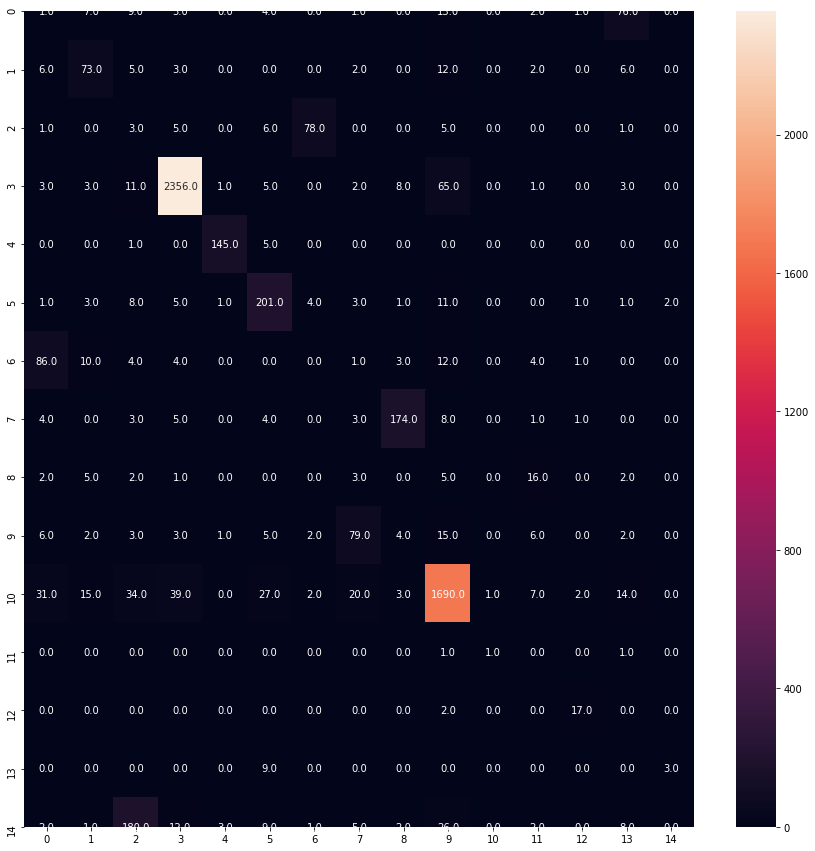

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(converted_label, averaged_label),annot=True,fmt='.1f')
plt.show()